### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [2]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [3]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

filepath = '/content/drive/My Drive/Assignments/As27_CNN on CIFAR/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# Hyperparameters
batch_size = 256
num_classes = 10
epochs = 50
l = 12
num_filter = 36
compression = 0.5

In [6]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [7]:
X_train.shape

(50000, 32, 32, 3)

In [8]:
X_test.shape

(10000, 32, 32, 3)

In [9]:
# Dense Block
def denseblock(input, num_filter = 12):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        # if dropout_rate>0:
        #     Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    # if dropout_rate>0:
    #      Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [10]:
input = layers.Input(shape=(img_height, img_width, channel))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter)
First_Transition = transition(First_Block, num_filter)

Second_Block = denseblock(First_Transition, num_filter)
Second_Transition = transition(Second_Block, num_filter)

Third_Block = denseblock(Second_Transition, num_filter)
Third_Transition = transition(Third_Block, num_filter)

Last_Block = denseblock(Third_Transition,  num_filter)
output = output_layer(Last_Block)

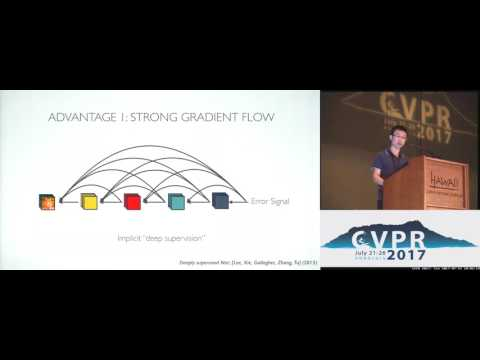

In [ ]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [11]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 36)   972         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 36)   144         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 36)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
print(len(model.layers))

211


In [13]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [14]:
# https://keras.io/api/preprocessing/image/#imagedatagenerator-class

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2,1],
    shear_range=0.15,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    validation_split=0.2,
    )

datagen.fit(X_train)

In [ ]:
tf.keras.backend.clear_session()
model.fit(datagen.flow(X_train, y_train, batch_size=batch_size, subset='training'),
          validation_data= datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation'),
          epochs=epochs, verbose=1)

save_model(model, filepath+'model_ckpt/epoch50.h5')

Epoch 1/50
157/157 [==============================] - 122s 508ms/step - loss: 1.7343 - accuracy: 0.3650 - val_loss: 1.6979 - val_accuracy: 0.3720
Epoch 2/50
157/157 [==============================] - 77s 491ms/step - loss: 1.3655 - accuracy: 0.5080 - val_loss: 1.8256 - val_accuracy: 0.3791
Epoch 3/50
157/157 [==============================] - 79s 499ms/step - loss: 1.1542 - accuracy: 0.5868 - val_loss: 1.4568 - val_accuracy: 0.4867
Epoch 4/50
157/157 [==============================] - 79s 500ms/step - loss: 1.0214 - accuracy: 0.6365 - val_loss: 1.1243 - val_accuracy: 0.6116
Epoch 5/50
157/157 [==============================] - 79s 501ms/step - loss: 0.9151 - accuracy: 0.6749 - val_loss: 0.9605 - val_accuracy: 0.6637
Epoch 6/50
157/157 [==============================] - 79s 501ms/step - loss: 0.8348 - accuracy: 0.7053 - val_loss: 0.9411 - val_accuracy: 0.6706
Epoch 7/50
157/157 [==============================] - 79s 500ms/step - loss: 0.7770 - accuracy: 0.7257 - val_loss: 1.0944 - val_a

In [15]:
# https://keras.io/api/callbacks/model_checkpoint/#:~:text=Callback%20to%20save%20the%20Keras,training%20from%20the%20state%20saved.
checkpoint_path = filepath +'model_ckpt/model_weights-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [20]:
tf.keras.backend.clear_session()
model = load_model(filepath+'model_ckpt/epoch50.h5')

model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'),
          validation_data= datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
          epochs=epochs, verbose=1, callbacks=[model_checkpoint, early_stopping])

Epoch 1/50
625/625 [==============================] - 121s 136ms/step - loss: 0.4625 - accuracy: 0.8411 - val_loss: 0.6715 - val_accuracy: 0.7827
Epoch 2/50
625/625 [==============================] - 84s 134ms/step - loss: 0.3886 - accuracy: 0.8643 - val_loss: 0.6135 - val_accuracy: 0.7968
Epoch 3/50
625/625 [==============================] - 84s 134ms/step - loss: 0.3608 - accuracy: 0.8759 - val_loss: 0.5220 - val_accuracy: 0.8237
Epoch 4/50
625/625 [==============================] - 84s 134ms/step - loss: 0.3427 - accuracy: 0.8788 - val_loss: 0.6065 - val_accuracy: 0.8030
Epoch 5/50
625/625 [==============================] - 84s 134ms/step - loss: 0.3325 - accuracy: 0.8853 - val_loss: 0.5770 - val_accuracy: 0.8189
Epoch 6/50
625/625 [==============================] - 84s 134ms/step - loss: 0.3261 - accuracy: 0.8867 - val_loss: 0.4851 - val_accuracy: 0.8411
Epoch 7/50
625/625 [==============================] - 84s 134ms/step - loss: 0.3179 - accuracy: 0.8891 - val_loss: 0.4414 - val_a

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [17]:
tf.keras.backend.clear_session()
# Weights loaded from 11th epoch of previous run
model = load_model(filepath+'model_ckpt/model_weights-07-0.8505.h5')

model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'),
          validation_data= datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
          epochs=epochs, verbose=1, callbacks=[model_checkpoint, early_stopping, lrop])

Epoch 1/50
625/625 [==============================] - 93s 137ms/step - loss: 0.3121 - accuracy: 0.8926 - val_loss: 0.6814 - val_accuracy: 0.7897
Epoch 2/50
625/625 [==============================] - 84s 134ms/step - loss: 0.3035 - accuracy: 0.8942 - val_loss: 0.4778 - val_accuracy: 0.8410
Epoch 3/50
625/625 [==============================] - 84s 134ms/step - loss: 0.2936 - accuracy: 0.8964 - val_loss: 0.4859 - val_accuracy: 0.8397
Epoch 4/50
625/625 [==============================] - 84s 134ms/step - loss: 0.2929 - accuracy: 0.8970 - val_loss: 0.4861 - val_accuracy: 0.8421
Epoch 5/50
625/625 [==============================] - 84s 134ms/step - loss: 0.2200 - accuracy: 0.9223 - val_loss: 0.3260 - val_accuracy: 0.8888
Epoch 6/50
625/625 [==============================] - 84s 134ms/step - loss: 0.1924 - accuracy: 0.9324 - val_loss: 0.3122 - val_accuracy: 0.8963
Epoch 7/50
625/625 [==============================] - 84s 134ms/step - loss: 0.1808 - accuracy: 0.9359 - val_loss: 0.3080 - val_ac

Best val_accuracy as of now is 0.9030 from previous run (10th epoch)


In [24]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

tf.keras.backend.clear_session()
# Weights loaded from 11th epoch of previous run
model = load_model(filepath+'model_ckpt/model_weights-10-0.9030.h5')

model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'),
          validation_data= datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
          epochs=epochs, verbose=1, callbacks=[model_checkpoint, early_stopping, lrop])

Epoch 1/50
625/625 [==============================] - 89s 137ms/step - loss: 0.1593 - accuracy: 0.9449 - val_loss: 0.3094 - val_accuracy: 0.8984
Epoch 2/50
625/625 [==============================] - 85s 136ms/step - loss: 0.1590 - accuracy: 0.9443 - val_loss: 0.3112 - val_accuracy: 0.9003
Epoch 3/50
625/625 [==============================] - 85s 135ms/step - loss: 0.1611 - accuracy: 0.9438 - val_loss: 0.2988 - val_accuracy: 0.9012
Epoch 4/50
625/625 [==============================] - 85s 136ms/step - loss: 0.1585 - accuracy: 0.9460 - val_loss: 0.3134 - val_accuracy: 0.8990
Epoch 5/50
625/625 [==============================] - 85s 136ms/step - loss: 0.1525 - accuracy: 0.9477 - val_loss: 0.3030 - val_accuracy: 0.9024
Epoch 6/50
625/625 [==============================] - 85s 135ms/step - loss: 0.1513 - accuracy: 0.9474 - val_loss: 0.3131 - val_accuracy: 0.9003
Epoch 7/50
625/625 [==============================] - 85s 135ms/step - loss: 0.1544 - accuracy: 0.9477 - val_loss: 0.3075 - val_ac

Best val_accuracy as of now is 0.9050 (10th epoch)

### Running more epochs to ensure model has convereged to global minima by further reducing batch_size to 32

In [27]:
tf.keras.backend.clear_session()
# Weights loaded from 11th epoch of previous run
model = load_model(filepath+'model_ckpt/model_weights-10-0.9050.h5')

model.fit(datagen.flow(X_train, y_train, batch_size=32, subset='training'),
          validation_data= datagen.flow(X_train, y_train, batch_size=32, subset='validation'),
          epochs=epochs, verbose=1, callbacks=[model_checkpoint, early_stopping, lrop])

Epoch 1/50
1250/1250 [==============================] - 99s 77ms/step - loss: 0.1691 - accuracy: 0.9414 - val_loss: 0.3152 - val_accuracy: 0.8982
Epoch 2/50
1250/1250 [==============================] - 95s 76ms/step - loss: 0.1698 - accuracy: 0.9406 - val_loss: 0.3094 - val_accuracy: 0.8967
Epoch 3/50
1250/1250 [==============================] - 95s 76ms/step - loss: 0.1687 - accuracy: 0.9403 - val_loss: 0.3119 - val_accuracy: 0.8998
Epoch 4/50
1250/1250 [==============================] - 95s 76ms/step - loss: 0.1698 - accuracy: 0.9415 - val_loss: 0.3158 - val_accuracy: 0.8993
Epoch 5/50
1250/1250 [==============================] - 95s 76ms/step - loss: 0.1728 - accuracy: 0.9391 - val_loss: 0.3099 - val_accuracy: 0.8984
Epoch 6/50
1250/1250 [==============================] - 95s 76ms/step - loss: 0.1691 - accuracy: 0.9408 - val_loss: 0.3066 - val_accuracy: 0.8995
Epoch 7/50
1250/1250 [==============================] - 95s 76ms/step - loss: 0.1725 - accuracy: 0.9400 - val_loss: 0.3073 -

### Final output

We can see that the best val_accuracy is 0.9050. Model seems to be converged

In [34]:
# Test the model
# Loaded the weights from 25th epoch of previous run
model_final = load_model(filepath+'model_ckpt/model_weights-10-0.9050.h5')
score = model_final.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 6s 18ms/step - loss: 0.3195 - accuracy: 0.9034
Test loss: 0.319461464881897
Test accuracy: 0.9034000039100647


In [35]:
# Save the trained weights in to .h5 format
model_final.save(filepath+ "model_ckpt/DNST_model.h5")
print("Saved model to disk")

Saved model to disk
